---
# Library importation
---

In [26]:
#Nettoyage/Visualisation des données
import pandas as pd
import pickle
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#Fonctions perso
from bibliotheque_ensta import *

#ML
import sklearn
from sklearn import ensemble
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_predict
#from sklearn.feature_selection import RFECV, SequentialFeatureSelector

#import catboost

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

#DL
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Input
from keras.callbacks import EarlyStopping

print("ok")

ok


In [27]:
#Rentrer nom de la base de données
base_de_donnees = 'SPMAuralA'
path = "/home4/datahome/rbessoua/comparaison/Pluie/"+base_de_donnees+"/"
path

'/home4/datahome/rbessoua/comparaison/Pluie/SPMAuralA/'

---
# Data importation/visualization
---

In [28]:
import os

nom_dir = "/home/datawork-osmose/dataset/"+base_de_donnees+"/analysis/getFeatures/32000/1H/"

os.chdir(nom_dir)
os.getcwd()

'/home/datawork-osmose/dataset/SPMAuralA/analysis/getFeatures/32000/1H'

In [29]:
ll = nom_dir + "complete.pkl"

[total_welch, total_tol, aux, total_time, frequencies] = pickle.load(open(ll, 'rb'))

In [30]:
X = prepa_total_tol_time(total_tol, total_time)

In [31]:
nom_dir = "/home/datawork-osmose/dataset/"+base_de_donnees+"/raw/auxiliary/"
os.chdir(nom_dir)
os.getcwd()

'/home/datawork-osmose/dataset/SPMAuralA/raw/auxiliary'

In [32]:
Y = pd.read_csv(base_de_donnees+'_y_final.csv')

In [33]:
data = pd.merge(X,Y, on=['year', 'month', 'day', 'hour'])
data['tp'] = data['tp']*1000
len(data)

3558

In [34]:
year_min = data.year.unique().min()
year_max = data.year.unique().max()

In [35]:
X = data.drop(['tp', 'u10','v10'], axis=1)

X_dl = X.values

min_max_scaler = MinMaxScaler()
X_dl = min_max_scaler.fit_transform(X_dl)

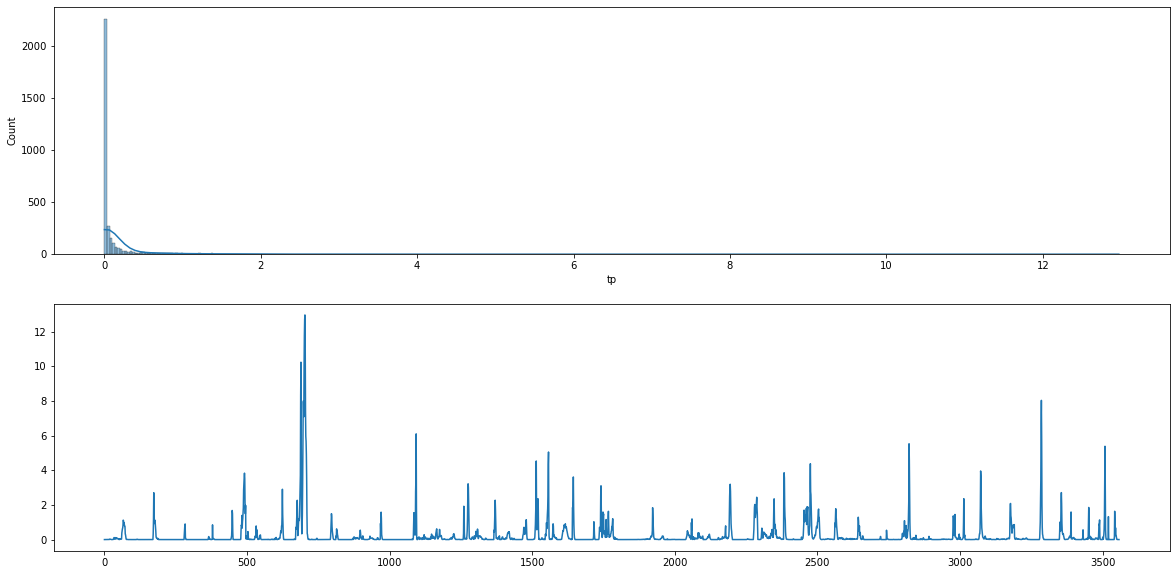

In [36]:
plt.figure(1,figsize=(20,10))
plt.subplot(2,1,1)
sns.histplot(data.tp, bins=400, kde=True)
plt.subplot(2,1,2)
plt.plot(data.tp)

We can see we have many rain events in our dataset, especially a big rain event.

---
# Rain Estimation :
---

First, we will try to predict precipitation rate with a Poisson neural network as we saw rain distribution seems to be a Poisson one.

Epoch 1/20
39/39 [==============================] - 1s 11ms/step - loss: 0.7245 - val_loss: 0.4833
Epoch 2/20
39/39 [==============================] - 0s 6ms/step - loss: 0.5858 - val_loss: 0.4431
Epoch 3/20
39/39 [==============================] - 0s 6ms/step - loss: 0.6295 - val_loss: 0.4958
Epoch 4/20
39/39 [==============================] - 0s 7ms/step - loss: 0.6830 - val_loss: 0.4595
Epoch 5/20
39/39 [==============================] - 0s 6ms/step - loss: 0.6560 - val_loss: 0.4413
Epoch 6/20
39/39 [==============================] - 0s 6ms/step - loss: 0.5653 - val_loss: 0.4649
Epoch 7/20
39/39 [==============================] - 0s 6ms/step - loss: 0.6160 - val_loss: 0.4732
Epoch 8/20
39/39 [==============================] - 0s 9ms/step - loss: 0.6443 - val_loss: 0.4226
Epoch 9/20
39/39 [==============================] - 0s 8ms/step - loss: 0.5914 - val_loss: 0.4879
Epoch 10/20
39/39 [==============================] - 0s 7ms/step - loss: 0.5940 - val_loss: 0.4817
Epoch 11/20
39/39 

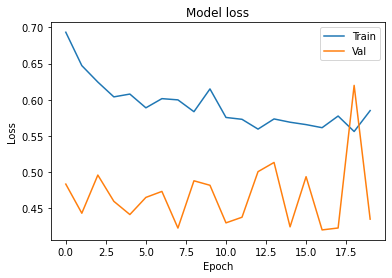

,Train MAE,Train R2,Test MAE,Test R2,Résultat
0,0.373045,-0.184705,0.357978,-0.170181,NN vent SPMAuralB


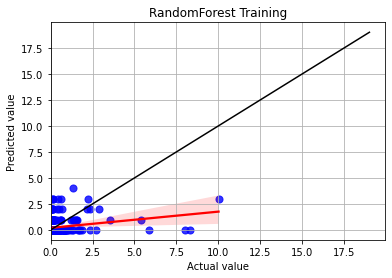

In [37]:
eval_nn_vent, model1, hist = lance_dl('NN vent SPMAuralB', 4, 200, X, data['tp'], epochs=20, batch_size=64, type_model = 'poisson',path=path+'70_poisson_res.png', save=True)
eval_nn_vent

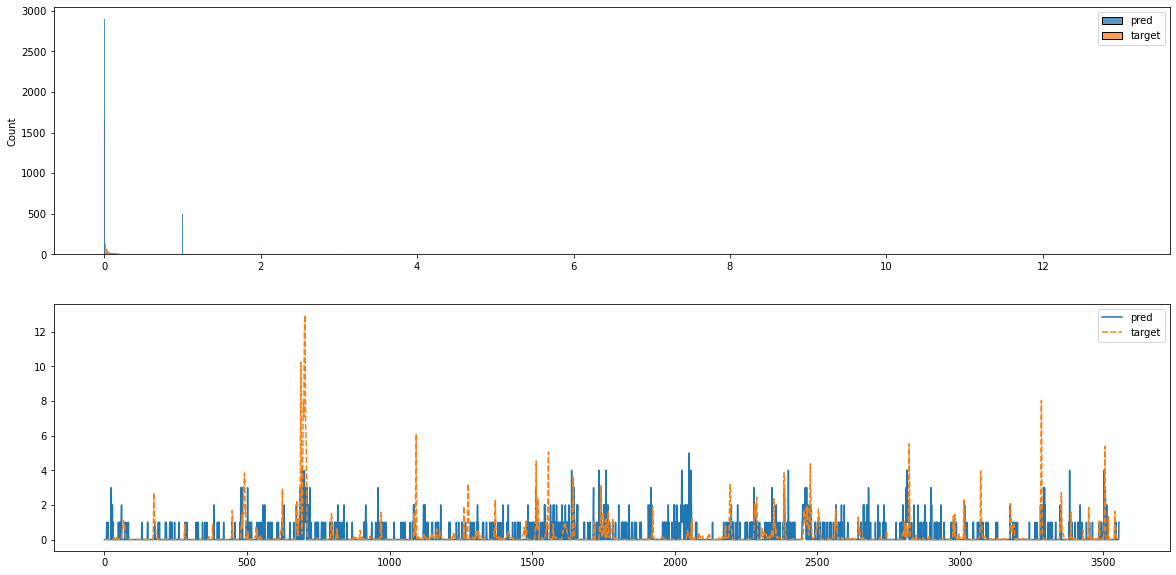

In [38]:
pred_nn_poisson = model1.predict(X_dl)
pred_nn_poisson = pred_nn_poisson.reshape(-1)

histo = pd.DataFrame(data={'pred':pred_nn_poisson, 'target':data['tp']})

plt.figure(1,figsize=(20,10))
plt.subplot(2,1,1)
sns.histplot(histo)
plt.subplot(2,1,2)
sns.lineplot(data = histo)
plt.savefig(path+'70_poisson_figure.png')

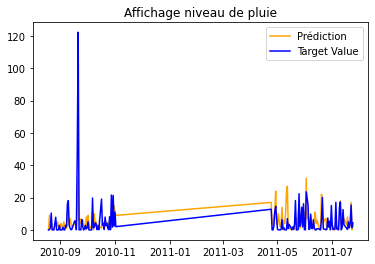

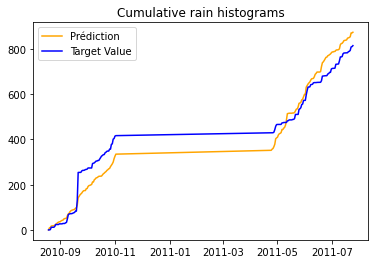

<Figure size 432x288 with 0 Axes>

In [39]:
df_poisson = pd.DataFrame(data={'pred':pred_nn_poisson.tolist(),'year':data.year,'month':data.month,'day':data.day,'hour':data.hour})

affi_target = build_affi_target_rain(data, target = 'tp')
affi_pred = build_affi_target_rain(df_poisson, target='pred')
affi_pred.columns = ['year','month','day','pred','date']

print_pluie(df1=affi_pred, df2=affi_target, year1=year_min, year2=year_max)
print_cumsum_pluie(df1=affi_pred, df2=affi_target, year1=year_min, year2=year_max, path = path+'70_poisson_cumsum.png',save=True)

We train our model with 70% of the data.

Comparing the distribution and repartition of predicted and target values, we can see our model doesn't follow rain events, it's not satisfying.
So we will try another approach.

## Second try : classification of rain event, then regression 

### Random Forest Classifier :

During our study, we define a rain event as an hour with a precipitation rate greater than one milimeter.

AxesSubplot(0.125,0.125;0.62x0.755)


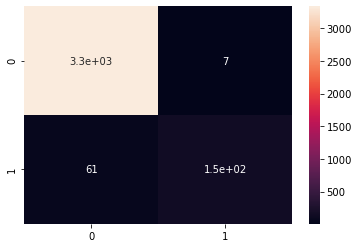

In [40]:
Y_rain = (data['tp']>1)*1

rain_rf, y_pred_rf = test_model_rf("", X, Y_rain, type_model = 'classification')

We can see our classifier correctly classify 70% of our rain events.

In [41]:
idx_faible = np.where(y_pred_rf==0)
idx_fort = np.where(y_pred_rf==1)

### Random Forest Regression :

In [42]:
X_regr, Y_regr =  donnees_regr_pluie(y_pred_rf, X, data['tp'])
print(f'We can see, in our regression dataset, we have {len(Y_regr)} elements, it corresponds to our classifier prediction in our dataset.')

We can see, in our regression dataset, we have 161 elements, it corresponds to our classifier prediction in our dataset.


,Train MAE,Train R2,Test MAE,Test R2,Résultat
0,0.472481,0.885972,1.352087,0.5414,RF Regr pluie SPMAuralB


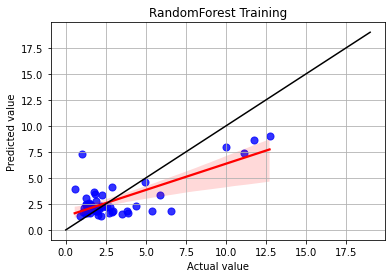

In [43]:
rf_rain_regr, eval_rf_regr_pluie, Y_test, y_pred_test = test_model_rf("RF Regr pluie SPMAuralB",X_regr, Y_regr,path=path+'70_rf_res.png',save=True)
eval_rf_regr_pluie

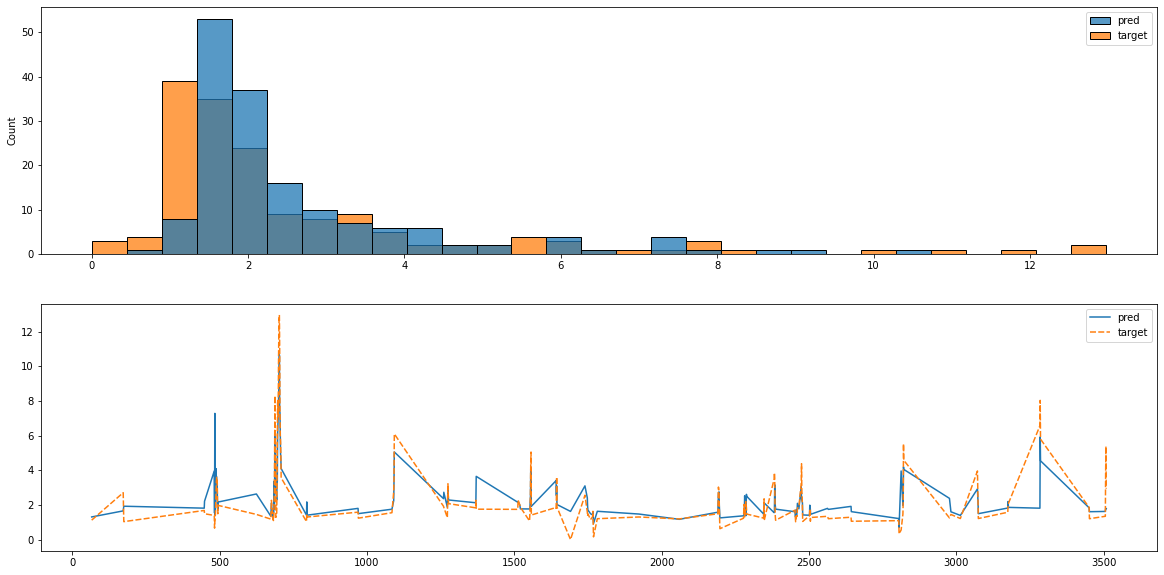

In [44]:
pred1 = rf_rain_regr.predict(X_regr)

histo = pd.DataFrame(data={'pred':pred1, 'target':Y_regr})

plt.figure(1,figsize=(20,10))
plt.subplot(2,1,1)
sns.histplot(histo)
plt.subplot(2,1,2)
sns.lineplot(data = histo)
plt.savefig(path+'70_rf_figure.png')

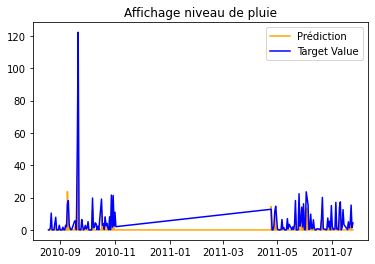

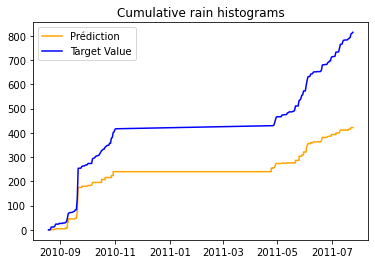

<Figure size 432x288 with 0 Axes>

In [45]:
affi_target = build_affi_target_rain(data, target = 'tp')
affi_pred3 = build_affi_pred_rain(data, y_pred_rf, pred1)

print_pluie(df1=affi_pred3, df2=affi_target, year1=year_min, year2=year_max)
print_cumsum_pluie(df1=affi_pred3, df2=affi_target, year1=year_min, year2=year_max, path=path+'70_rf_cumsum.png', save=True)

***Final prediction :***

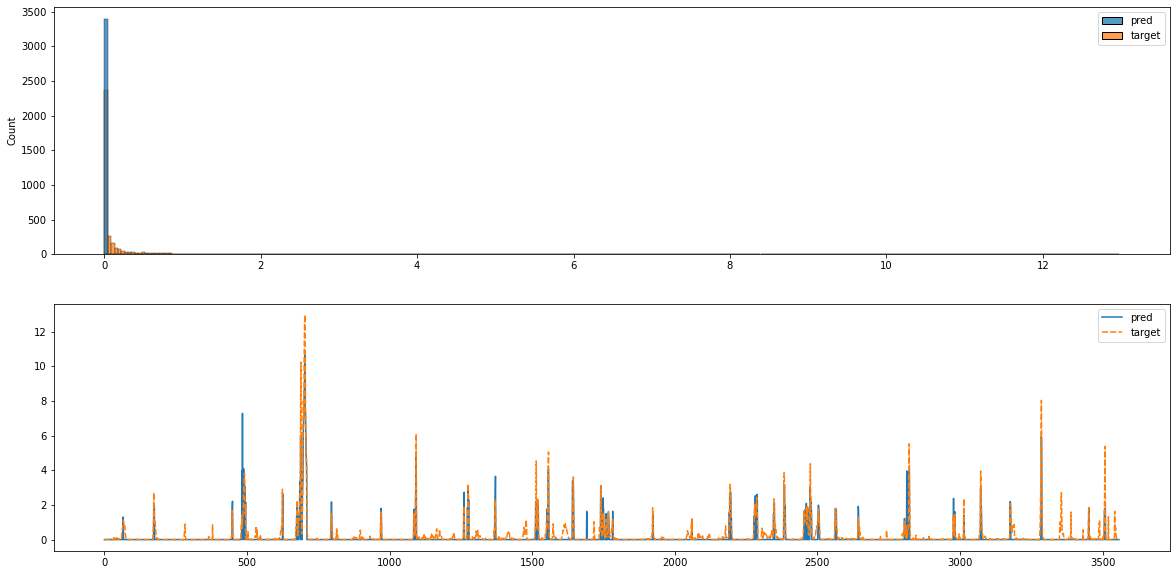

In [46]:
res=[0 for i in range(len(X))]
for i, j in enumerate (idx_faible[0]):
    res[j] = 0
for i, j in enumerate(idx_fort[0]):
    res[j] = pred1[i]

histo = pd.DataFrame(data={'pred':res, 'target':data['tp']})

plt.figure(1,figsize=(20,10))
plt.subplot(2,1,1)
sns.histplot(histo, bins=300)
plt.subplot(2,1,2)
sns.lineplot(data = histo)
plt.savefig(path+'70_rf_pred_finale.png')

We train our model with 70% of the data.

The predict distribution isn't the same in regard of the target one. But for the repartition of the prediction, we detect most of rain events.

### Neural Network regression

Now we will use a classic neural network architecture to make the regression of precipitation rate.

Epoch 1/15
7/7 [==============================] - 1s 70ms/step - loss: 9.7464 - accuracy: 0.0000e+00 - val_loss: 3.8998 - val_accuracy: 0.0000e+00
Epoch 2/15
7/7 [==============================] - 0s 21ms/step - loss: 4.5662 - accuracy: 0.0000e+00 - val_loss: 3.5937 - val_accuracy: 0.0000e+00
Epoch 3/15
7/7 [==============================] - 0s 22ms/step - loss: 5.2645 - accuracy: 0.0000e+00 - val_loss: 3.9429 - val_accuracy: 0.0000e+00
Epoch 4/15
7/7 [==============================] - 0s 15ms/step - loss: 4.1714 - accuracy: 0.0000e+00 - val_loss: 3.5361 - val_accuracy: 0.0000e+00
Epoch 5/15
7/7 [==============================] - 0s 21ms/step - loss: 3.9263 - accuracy: 0.0000e+00 - val_loss: 3.6459 - val_accuracy: 0.0000e+00
Epoch 6/15
7/7 [==============================] - 0s 23ms/step - loss: 4.7055 - accuracy: 0.0000e+00 - val_loss: 3.5717 - val_accuracy: 0.0000e+00
Epoch 7/15
7/7 [==============================] - 0s 21ms/step - loss: 3.3897 - accuracy: 0.0000e+00 - val_loss: 3.735

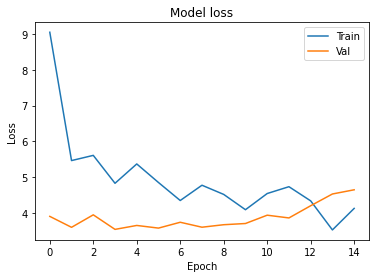

,Train MAE,Train R2,Test MAE,Test R2,Résultat
0,1.139957,0.285327,1.577329,0.211111,NN Regr pluie SPMAuralB


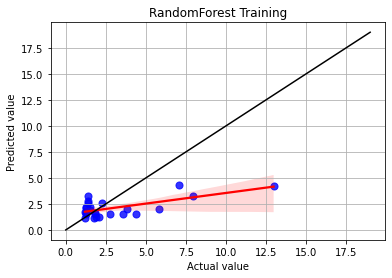

In [47]:
eval_nn_pluie, model2, hist = lance_dl("NN Regr pluie SPMAuralB", 4, 32, X_regr, Y_regr, epochs=15, batch_size=16, type_model = 'normal', path=path+'70_nn_res.png', save=True)
eval_nn_pluie

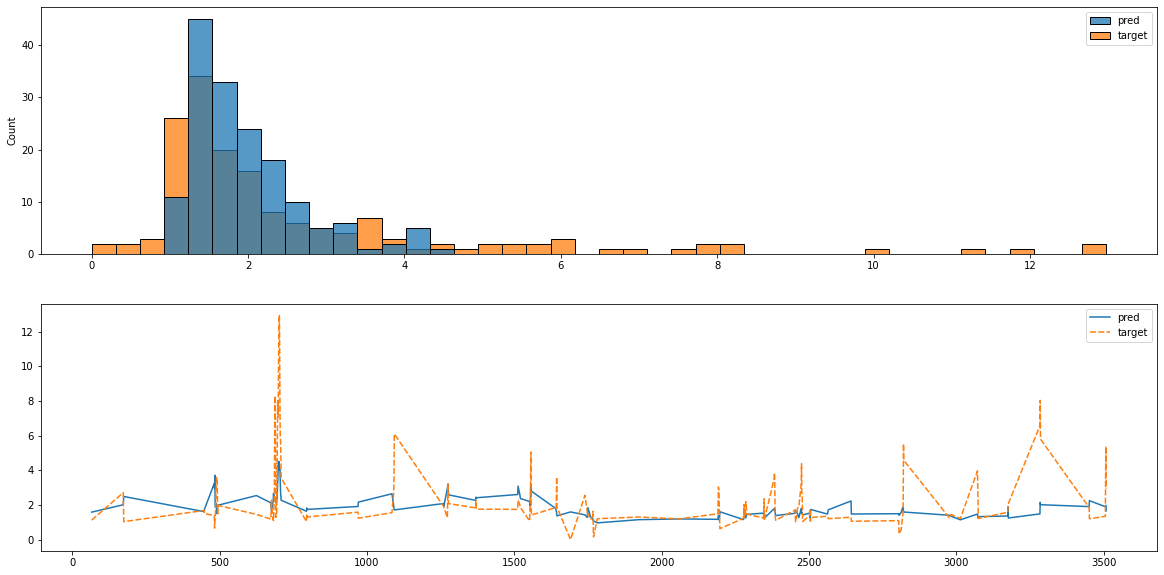

In [48]:
X_dl = X_regr.values

min_max_scaler = MinMaxScaler()
X_dl = min_max_scaler.fit_transform(X_dl)

pred_nn_rain = model2.predict(X_dl)
pred_nn_rain = pred_nn_rain.reshape(-1)

histo = pd.DataFrame(data={'pred':pred_nn_rain, 'target':Y_regr})

plt.figure(1,figsize=(20,10))
plt.subplot(2,1,1)
sns.histplot(histo)
plt.subplot(2,1,2)
sns.lineplot(data = histo)
plt.savefig(path+'70_nn_figure.png')

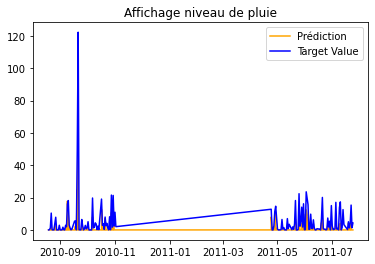

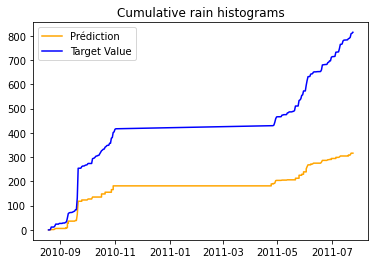

<Figure size 432x288 with 0 Axes>

In [49]:
affi_target = build_affi_target_rain(data, target = 'tp')
affi_pred3 = build_affi_pred_rain(data, y_pred_rf, pred_nn_rain)

print_pluie(df1=affi_pred3, df2=affi_target, year1=year_min, year2=year_max)
print_cumsum_pluie(df1=affi_pred3, df2=affi_target, year1=year_min, year2=year_max, path=path+'70_nn_cumsum.png',save=True)

***Final prediction***

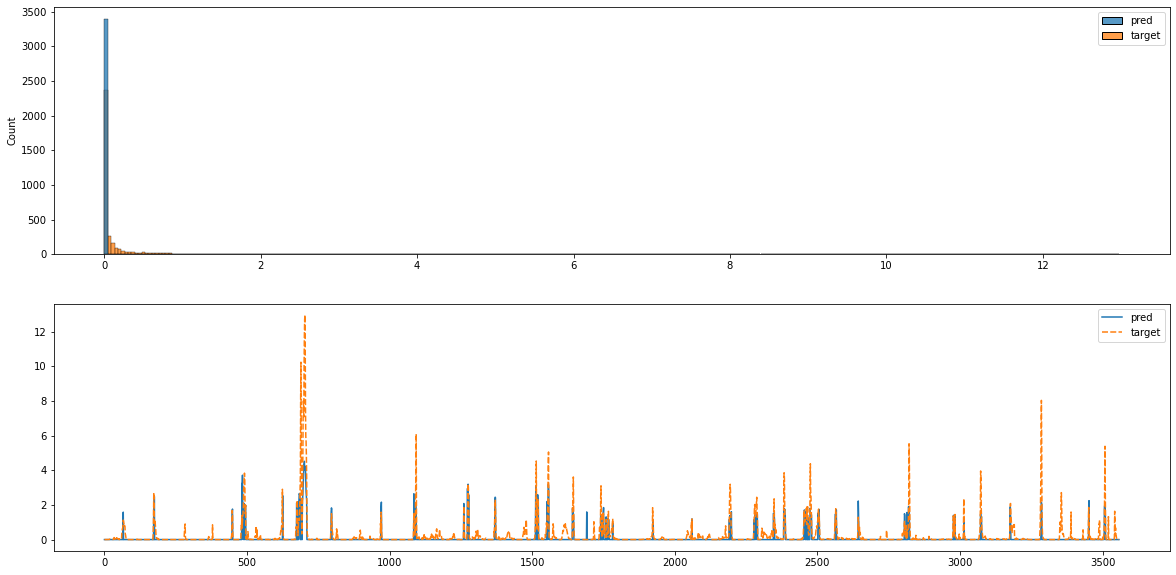

In [50]:
res=[0 for i in range(len(X))]
for i, j in enumerate (idx_faible[0]):
    res[j] = 0
for i, j in enumerate(idx_fort[0]):
    res[j] = pred_nn_rain[i]

histo = pd.DataFrame(data={'pred':res, 'target':data['tp']})

plt.figure(1,figsize=(20,10))
plt.subplot(2,1,1)
sns.histplot(histo, bins=300)
plt.subplot(2,1,2)
sns.lineplot(data = histo)
plt.savefig(path+'70_nn_pred_finale.png')

On the top figure, we can see the final neural network prediction coupled with the random forest classifier.

This model is not as good as the previous one but we detect well some rain events. But we havn't a good precipitation rate estimation.

However, we have to be careful about the overfitting of the first random forest model.